# Variational quantum classifier

1. Create dataset training and testing data points with 2 features

In [17]:
from qiskit.utils import algorithm_globals
import numpy as np
from qiskit_machine_learning.datasets import ad_hoc_data

algorithm_globals.random_seed = 3142

np.random.seed(algorithm_globals.random_seed)

# then get training and test data from qiskit_machine_learning datasets
train_data, train_labels, test_data, test_labels = ad_hoc_data(training_size = 20, test_size = 5, n = 2, gap = 0.3, one_hot = False)

2. Create a classifier, use the Qiskit ZZFeatureMap as the encoding circuit and the Qiskit TwoLocal circuit as the variational circuit

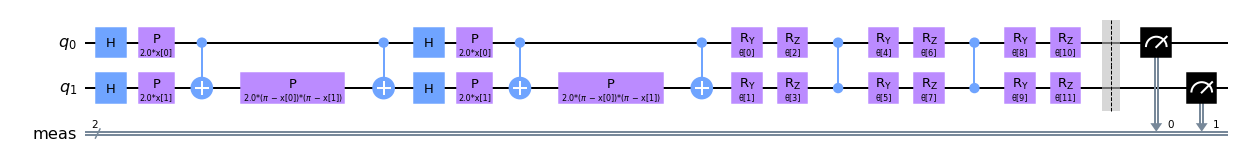

In [18]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
import matplotlib as plt

feature_map = ZZFeatureMap(feature_dimension = 2, reps = 2)
var_circuit = TwoLocal(2, ['ry', 'rz'], 'cz', reps = 2)

total_circuit = feature_map.compose(var_circuit)
total_circuit.measure_all()

%matplotlib inline
total_circuit.decompose().draw('mpl')

3. Function to encode data into the feature map and the variational parameters to the variational circuit

In [19]:
def circuit_parameters(data, variational) :
    parameters = {}

    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]

    for i, p in enumerate(var_circuit.ordered_parameters):
        parameters[p] = variational[i]

    return parameters

4. Create a label assign function to calculate label, which is this case is the parity of the bitstring
* if parity is even, label is 1, else label is 0

In [20]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])

    odd = hamming_weight & 1
    
    if odd:
        return 0
    else:
        return 1

5. Create a function that returns the probability distribution over the label classes

In [21]:
def probability_distribution(results):
    shots = sum(results.values())

    probabilities = {
        0: 0, 
        1: 0
    }

    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots

    return probabilities


6. Function that classifies the data, for all data points assign parameters to both sub routines, evolve the system and store the circuit for running at once at the end and return probability distribution

In [22]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [total_circuit.assign_parameters(circuit_parameters(d, variational)) for d in data]

    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()

    classification = [probability_distribution(results.get_counts(c)) for c in circuits]

    return classification

7. For the training we need the list and cost functions

* For the loss function we use herer the so called Cross-entropy loss, which is used for classification models, here in the context of discrete probability distributions (https://en.m.wikipedia.org/wiki/Cross_entropy)

$$H(p) = - \sum p(x) log(q(x))$$

where p(x) in the current context is the probability of one distribution and q(x) is the probability of the other distribution

In [23]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    
    return -(expected * np.log(p) + (1 - expected) * np.log(1 - p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)

    cost = 0
    
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

8. Use the classical optimisation with SPSA

In [25]:
from qiskit.algorithms.optimizers import SPSA

evaluations = []
parameters = []
costs = []

def opt_callback_function(eval, parameter, cost, stepsize, accepted):
    evaluations.append(eval)
    parameters.append(parameter)
    costs.append(cost)

optimizer = SPSA(maxiter = 100, callback = opt_callback_function)

# we put hardcoded some initial point
initial_point = np.array([
    3.28559355, 5.48514978, 5.13099949,
    0.88372228, 4.08885928, 2.45568528,
    4.92364593, 5.59032015, 3.66837805,
    4.84632313, 3.60713748, 2.43546
])

# continue with the optimisation
objective_function = lambda variational: cost_function(train_data,  train_labels, variational)

opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function = objective_function, initial_point = initial_point)

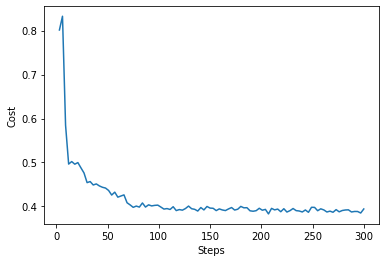

In [31]:
# Finally plot the results
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

9. We need to check the score of our classifier and test in with the test data

In [33]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(test_data, test_labels, opt_var)
accuracy

0.4

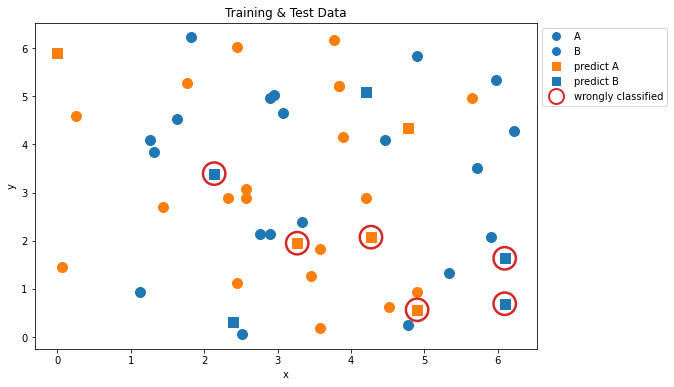

In [35]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels):
    marker = 'o' 

    color = 'C0' if label == 0 else 'C1'

    plt.scatter(feature[0], feature[1], marker = marker, s = 100, color = color)
    
for feature, label, pred in zip(test_data, test_labels, prediction):
    marker = 's' 
    color = 'C0' if pred == 0 else 'C1'

    plt.scatter(feature[0], feature[1], marker = marker, s = 100, color = color)

    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker = 'o', s = 500, linewidths = 2.5, facecolor = 'none', edgecolor = 'C3')

legend_elements = [
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'C0', label = 'A', ms=10),
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'C0', label = 'B', ms=10),
    Line2D([0], [0], marker = 's', c = 'w', mfc = 'C1', label = 'predict A', ms = 10),
    Line2D([0], [0], marker = 's', c='w', mfc='C0', label = 'predict B', ms = 10),
    Line2D([0], [0], marker = 'o', c = 'w', mfc = 'none', mec = 'C3', label = 'wrongly classified', mew = 2, ms = 15)
]

plt.legend(handles=legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()